# Needle-in-Haystack Benchmark Notebook

This notebook measures the performance of a “needle in a haystack” lookup query—finding one specific row among many—for three storage backends: SQLite, MongoDB, and ParquetDB.

---

## Benchmark Details

- **Data Generation:**  
  - Each run generates *N* rows × 100 columns of integers, with exactly one row set to `–1` (“the needle”) and all other entries random in [0, 1 000 000].  
  - Row counts tested: `1, 10, 100, 1 000, 10 000, 100 000, 1 000 000`.  
  - Integers chosen as a basic primitive type—byte size is the main factor, so these results represent a **lower bound** on query time. More complex or larger types will incur higher cost.

- **Parquet Normalization Settings (defaults):**  
  - **Row‐group size:** 50 000–100 000 rows per group  
  - **Max rows per file:** 10 000 000  
  - Tuning these can shift performance between inserts, reads, and updates.

---

## System Specifications

- **OS:** Windows 10  
- **CPU:** AMD Ryzen 7 3700X @ 3.6 GHz (8 physical cores, 16 logical)  
- **RAM:** 128 GB DDR4‑3600 MHz (4×32 GB)  

---

## 1. Setup

In [1]:
import os
import time
import random
import shutil
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pymongo import MongoClient
import pyarrow.compute as pc

from parquetdb import ParquetDB, config


bench_dir = os.path.join(config.data_dir, "benchmarks")
sqlite_dir = os.path.join(bench_dir, "sqlite")
mongo_dir  = os.path.join(bench_dir, "mongodb")
pq_dir     = os.path.join(bench_dir, "parquetdb")
for d in (sqlite_dir, mongo_dir, pq_dir):
    os.makedirs(d, exist_ok=True)

row_counts = [1, 10, 100, 1_000, 10_000, 100_000, 1_000_000]
n_cols = 100

## 2. SQLite Becnhmark

### 2.1 Helper functions

In [2]:
def generate_data_sqlite(n_rows, n_cols=100, needle=-1):
    idx = random.randrange(n_rows)
    data = []
    for i in range(n_rows):
        vals = [needle]*n_cols if i == idx else [random.randint(0,1_000_000) for _ in range(n_cols)]
        data.append(tuple(vals))
    return data

def run_sqlite(n_rows, use_index):
    db_file = os.path.join(sqlite_dir, f"bench_{n_rows}_{'idx' if use_index else 'noidx'}.db")
    if os.path.exists(db_file): os.remove(db_file)

    # Insert
    start = time.time()
    conn = sqlite3.connect(db_file)
    cols = ", ".join(f"col{i} INTEGER" for i in range(n_cols))
    conn.execute(f"CREATE TABLE t ({cols})")
    conn.execute("PRAGMA synchronous = OFF")
    conn.execute("PRAGMA journal_mode = MEMORY")
    placeholders = ", ".join("?" for _ in range(n_cols))
    conn.executemany(f"INSERT INTO t VALUES ({placeholders})", generate_data_sqlite(n_rows, n_cols))
    conn.commit()
    conn.close()
    insert_time = time.time() - start

    # Optional index
    if use_index:
        conn = sqlite3.connect(db_file)
        conn.execute("CREATE INDEX idx_col0 ON t(col0)")
        conn.commit()
        conn.close()

    # Query
    start = time.time()
    conn = sqlite3.connect(db_file)
    cur = conn.cursor()
    cur.execute("SELECT col0 FROM t WHERE col0 = -1")
    assert cur.fetchone()[0] == -1
    conn.close()
    read_time = time.time() - start

    return insert_time, read_time

### 2.2 Run without Index

In [3]:
results_sqlite = {"n_rows": [], "insert_noidx": [], "read_noidx": []}
for n in row_counts:
    it, rt = run_sqlite(n, use_index=False)
    results_sqlite["n_rows"].append(n)
    results_sqlite["insert_noidx"].append(it)
    results_sqlite["read_noidx"].append(rt)
df_sqlite_noidx = pd.DataFrame(results_sqlite)
df_sqlite_noidx.to_csv(os.path.join(sqlite_dir, "sqlite_noidx.csv"), index=False)

### 2.3 Run with Index

In [4]:
results_sqlite_idx = {"n_rows": [], "insert_idx": [], "read_idx": []}
for n in row_counts:
    it, rt = run_sqlite(n, use_index=True)
    results_sqlite_idx["n_rows"].append(n)
    results_sqlite_idx["insert_idx"].append(it)
    results_sqlite_idx["read_idx"].append(rt)
df_sqlite_idx = pd.DataFrame(results_sqlite_idx)
df_sqlite_idx.to_csv(os.path.join(sqlite_dir, "sqlite_idx.csv"), index=False)

## 3. MongoDB Benchmark

### 3.1 Helper functions

In [5]:
def generate_data_mongo(n_rows, n_cols=100, needle=-1):
    idx = random.randrange(n_rows)
    docs = []
    for i in range(n_rows):
        base = {f"col_{j}": needle for j in range(n_cols)} if i == idx else \
               {f"col_{j}": random.randint(0,1_000_000) for j in range(n_cols)}
        docs.append(base)
    return docs

def run_mongo(n_rows, use_index):
    client = MongoClient("mongodb://localhost:27017/")
    db = client.benchmark
    coll = db.t
    client.drop_database("benchmark")

    # Insert
    start = time.time()
    coll.insert_many(generate_data_mongo(n_rows, n_cols))
    insert_time = time.time() - start

    # Index?
    if use_index:
        coll.create_index("col_0")

    # Query
    start = time.time()
    res = list(coll.find({"col_0": -1}, {"col_0":1, "_id":0}))
    assert res[0]["col_0"] == -1
    read_time = time.time() - start
    client.close()

    return insert_time, read_time

### 3.2 Run without Index

In [6]:
results_mongo_noidx = {"n_rows": [], "insert_noidx": [], "read_noidx": []}
for n in row_counts:
    it, rt = run_mongo(n, use_index=False)
    results_mongo_noidx["n_rows"].append(n)
    results_mongo_noidx["insert_noidx"].append(it)
    results_mongo_noidx["read_noidx"].append(rt)
df_mongo_noidx = pd.DataFrame(results_mongo_noidx)
df_mongo_noidx.to_csv(os.path.join(mongo_dir, "mongo_noidx.csv"), index=False)

In [14]:
df_mongo_noidx.head()

,n_rows,insert_noidx,read_noidx
0,1,0.018000,0.000000
1,10,0.012573,0.000000
2,100,0.023000,0.000000
3,1000,0.139594,0.002002
4,10000,1.114362,0.007001


### 3.3 Run with Index

In [7]:
results_mongo_idx = {"n_rows": [], "insert_idx": [], "read_idx": []}
for n in row_counts:
    it, rt = run_mongo(n, use_index=True)
    results_mongo_idx["n_rows"].append(n)
    results_mongo_idx["insert_idx"].append(it)
    results_mongo_idx["read_idx"].append(rt)
df_mongo_idx = pd.DataFrame(results_mongo_idx)
df_mongo_idx.to_csv(os.path.join(mongo_dir, "mongo_idx.csv"), index=False)

## 4. ParquetDB Benchmark

### 4.1 Helper functions

In [8]:
def generate_data_pq(n_rows, n_cols=100, needle=-1):
    # one dict per row
    idx = random.randrange(n_rows)
    data = []
    for i in range(n_rows):
        row = {f"col_{j}": (needle if i == idx else random.randint(0,1_000_000))
               for j in range(n_cols)}
        data.append(row)
    return data

def run_parquetdb(n_rows):
    db_path = os.path.join(pq_dir, f"bench_{n_rows}")
    if os.path.exists(db_path): shutil.rmtree(db_path)
    db = ParquetDB(db_path=db_path)
    start = time.time()
    db.create(generate_data_pq(n_rows, n_cols))
    insert_time = time.time() - start

    start = time.time()
    tbl = db.read(columns=["col_0"], filters=[pc.field("col_0")==-1]).combine_chunks()
    assert tbl["col_0"].to_pylist()[0] == -1
    read_time = time.time() - start

    return insert_time, read_time

### 4.2 Run ParquetDB

In [9]:
results_pq = {"n_rows": [], "insert": [], "read": []}
for n in row_counts:
    it, rt = run_parquetdb(n)
    results_pq["n_rows"].append(n)
    results_pq["insert"].append(it)
    results_pq["read"].append(rt)
df_pq = pd.DataFrame(results_pq)
df_pq.to_csv(os.path.join(pq_dir, "parquetdb_needle_bench.csv"), index=False)

[INFO] 2025-04-19 12:26:47 - parquetdb.core.parquetdb[205][__init__] - Initializing ParquetDB with db_path: Z:\data\parquetdb\data\benchmarks\parquetdb\bench_1
[INFO] 2025-04-19 12:26:47 - parquetdb.core.parquetdb[207][__init__] - verbose: 1


## 5. Load & Preview All Results

In [10]:
df_sql_no = pd.read_csv(os.path.join(sqlite_dir, "sqlite_noidx.csv"))
df_sql_ix = pd.read_csv(os.path.join(sqlite_dir, "sqlite_idx.csv"))
df_mg_no = pd.read_csv(os.path.join(mongo_dir, "mongo_noidx.csv"))
df_mg_ix = pd.read_csv(os.path.join(mongo_dir, "mongo_idx.csv"))
df_pq    = pd.read_csv(os.path.join(pq_dir, "parquetdb_needle_bench.csv"))

# Combine for plotting

## 6. Plot Read Times

C:\Users\lllang\AppData\Local\Temp\ipykernel_22252\3519610802.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


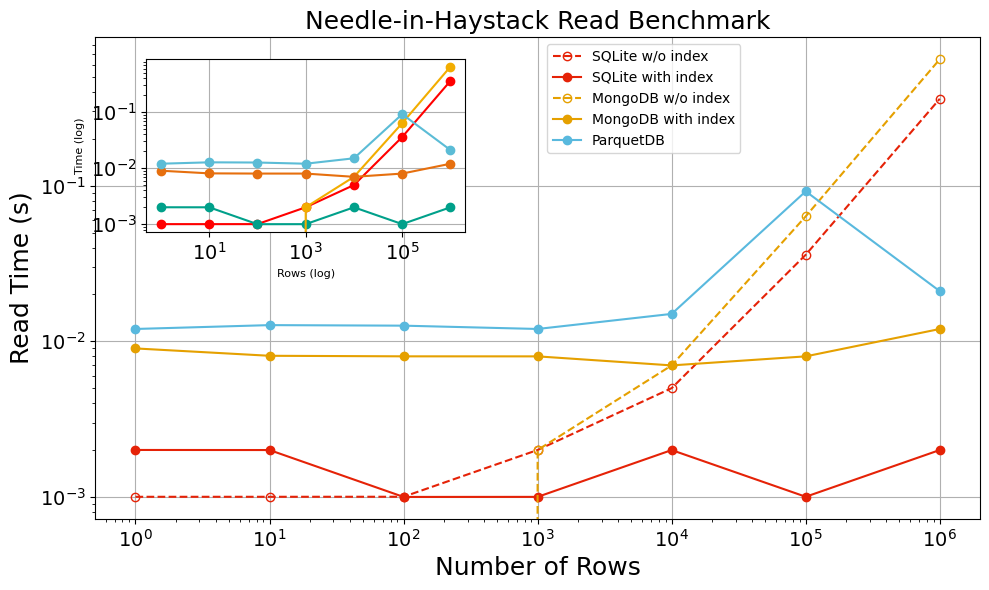

In [13]:
plt.rcParams.update({
    "axes.labelsize": 18, "axes.titlesize": 18,
    "xtick.labelsize":14, "ytick.labelsize":14,
})
fig, ax = plt.subplots(figsize=(10,6))

colors = {"sqlite":"#e52207", "mongodb":"#e5a000", "parquetdb":"#59b9de"}

# SQLite
ax.plot(df_sql_no["n_rows"], df_sql_no["read_noidx"],
        label="SQLite w/o index", color=colors["sqlite"], linestyle="dashed", marker="o", fillstyle="none")
ax.plot(df_sql_ix["n_rows"], df_sql_ix["read_idx"],
        label="SQLite with index", color=colors["sqlite"], linestyle="solid", marker="o")

# MongoDB
ax.plot(df_mg_no["n_rows"], df_mg_no["read_noidx"],
        label="MongoDB w/o index", color=colors["mongodb"], linestyle="dashed", marker="o", fillstyle="none")
ax.plot(df_mg_ix["n_rows"], df_mg_ix["read_idx"],
        label="MongoDB with index", color=colors["mongodb"], linestyle="solid", marker="o")

# ParquetDB
ax.plot(df_pq["n_rows"], df_pq["read"],
        label="ParquetDB", color=colors["parquetdb"], linestyle="solid", marker="o")

ax.set_xlabel("Number of Rows")
ax.set_ylabel("Read Time (s)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True)

# Inset
ax_in = inset_axes(ax, width="36%", height="36%", loc="upper left",
                   bbox_to_anchor=(0.05,-0.03,1,1), bbox_transform=ax.transAxes)
for label, df_ in [("SQLite no idx", df_sql_no), ("SQLite idx", df_sql_ix),
                   ("Mongo no idx", df_mg_no), ("Mongo idx", df_mg_ix),
                   ("ParquetDB", df_pq)]:
    ax_in.plot(df_["n_rows"], df_.filter(like="read"), marker="o", label=label)
ax_in.set_xscale("log"); ax_in.set_yscale("log")
ax_in.set_xlabel("Rows (log)", fontsize=8)
ax_in.set_ylabel("Time (log)", fontsize=8)
ax_in.grid(True)

ax.legend(loc="upper center", bbox_to_anchor=(0.12,0,1,1))
ax.set_title("Needle‑in‑Haystack Read Benchmark")
plt.tight_layout()
plt.show()

## 6. Discussion

1. **Absolute performance hierarchy**  
   - **SQLite with index** is consistently the fastest lookup engine across all scales—about an order of magnitude faster than any other backend.  
   - **MongoDB with index** trails SQLite by a small constant factor but remains a solid 2nd place when an index is present.  
   - **ParquetDB** (no secondary index) starts off in the middle, beating MongoDB w/o index but behind both indexed engines, but still competitive.

2. **Scalability of row‑based vs. columnar**  
   - Both **SQLite** and **MongoDB without an index** degrade rapidly as row‑count grows, owing to their full‑table scans.  
   - ParquetDB’s read time is flat up to ~100 K rows—then matches a full‑scan profile at 10 K and 100 K, before **diverging back to a faster slope at 1 M**.

3. **Why ParquetDB “bounces back” at 1 M rows**  
   - ≤ 100 K rows ⇒ only **1 row‑group** in the file ⇒ single‑threaded scan of all pages  
   - 1 M rows  ⇒ **10 row‑groups** ⇒ PyArrow’s multithreading + row‑group skipping via metadata statistics kicks in ⇒ turnaround time drops below the single‑scan curve

4. **Index‑scan overhead trade‑offs**  
   - MongoDB with an index is slightly slower than a full scan for very small tables (≤ 100 rows).  
   - At tiny scales the “binary tree walk + random I/O” of an index can actually cost more than a pure sequential scan.

5. **Takeaways & tuning knobs**  
   - For **point‑look workloads** on small to moderate data sizes, traditional row‑stores with an index remain unbeatable.  
   - For **very large datasets**, a columnar engine that can skip entire row‑groups and leverage multithreading can reclaim the lead—even without a secondary index.  
   - **Row‑group size** is your key tuning parameter in ParquetDB: smaller groups lower latency for medium‑sized tables, while larger groups boost throughput on huge tables.
